In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import itertools as it
from glob import glob
from matplotlib import pyplot as plt
from pymea import plotting
from pymea import matlab_compatibility as mc

In [3]:
data_path = '/home/sean/mea data/vglut01/vglut01_170911/vglut01_spk_freq_table_170911.csv'
data_table = pd.read_csv(data_path)
time_vector = data_table['time'].map(mc.datetime_str_to_datetime)

In [4]:
condition_cols = {
    'NaCl': 1,
    'DTX_10nM': 2,
    'DTX_100nM': 3,
    'PTX_0.5uM': 4,
    'Control': 5,
    'Ba_0.1mM': 6,
    'KCl_0.1mM': 7,
    'DMSO': 8,
}

def create_well_assignment_filter(cond_name):
    def well_assignment_filter(unit_name):
        col = mc.get_col_number(unit_name)
        return col == condition_cols[cond_name]
    return well_assignment_filter

well_filter_dict = {cond_name: create_well_assignment_filter(cond_name) for cond_name in condition_cols.iterkeys()}


In [5]:
cat_table = plotting.construct_categorized_dataframe(data_table, well_filter_dict)
cat_table['spike_freq'] = cat_table['spike_freq']/60 # convert from spikes/1 minute to spikes/second

In [6]:
cat_table_orig = cat_table

In [7]:
# get rid of times at beginning and end of each 1 hr recording
cat_table = cat_table.query('''(time > "2017-09-11 13:17:00" and time < "2017-09-11 17:17:00") \
                       | (time > "2017-09-12 10:50:00" & time < "2017-09-12 12:40:00") \
                       | (time > "2017-09-12 13:07:00" & time < "2017-09-12 14:23:00") \
                       | (time > "2017-09-12 14:26:00" & time < "2017-09-12 16:28:00") \
                       | (time > "2017-09-13 15:55:00" & time < "2017-09-14 03:00:00") \
                       | (time > "2017-09-14 09:18:00" & time < "2017-09-15 07:00:00") \
                       | (time > "2017-09-15 10:57:00" & time < "2017-09-15 16:00:00") ''')
cat_table_reachr = cat_table_orig.query('''(time > "2017-09-11 13:17:00" & time < "2017-09-11 17:17:00") \
                       | (time > "2017-09-11 17:31:00" & time < "2017-09-11 21:30:00")''')

In [8]:
cat_table['spike_freq'] = plotting.smooth(cat_table['spike_freq'], kernel_size=20) # smooth using a 20 minute kernel

/home/sean/anaconda3/envs/ipykernel_py2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [9]:
#baseline
baseline1 = cat_table.query('time > "2017-09-12 10:47:00"').query('time < "2017-09-12 12:40:00"')
baseline2 = cat_table.query('time > "2017-09-11 13:17:00" and time < "2017-09-11 17:17:00"')
baseline_table = pd.concat([baseline2, baseline1])
stim_table = cat_table.query('time > "2017-09-12 13:07:00"')

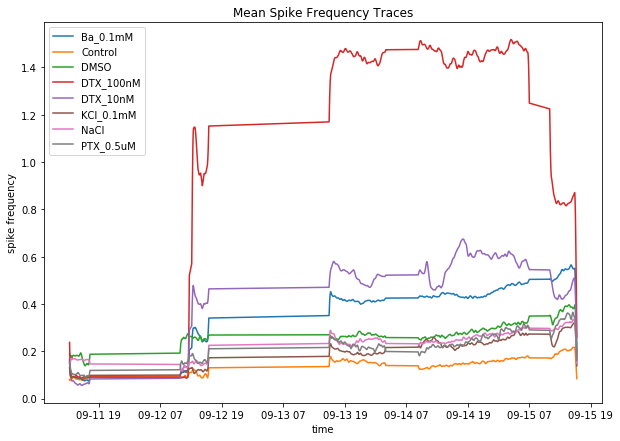

In [57]:
plt.figure(figsize=(10,7))
plotting.plot_mean_frequency_traces(cat_table)

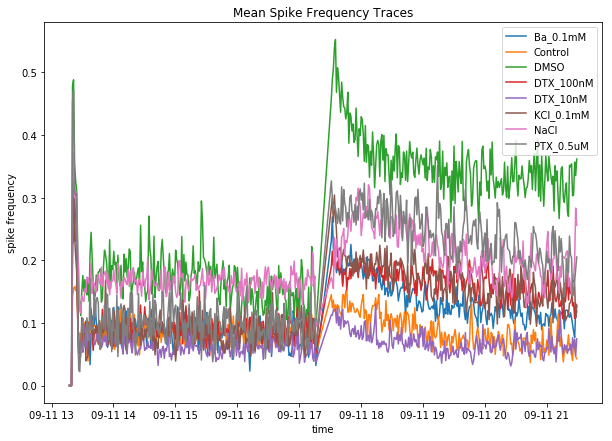

In [58]:
plt.figure(figsize=(10,7))
plotting.plot_mean_frequency_traces(cat_table_reachr)

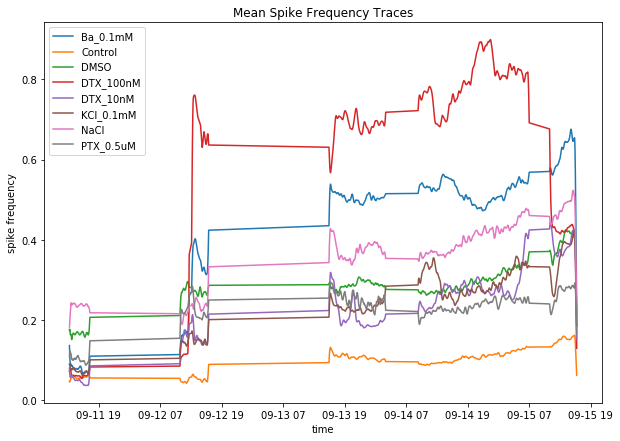

In [59]:
plt.figure(figsize=(10,7))
plotting.plot_mean_frequency_traces(cat_table_exc)

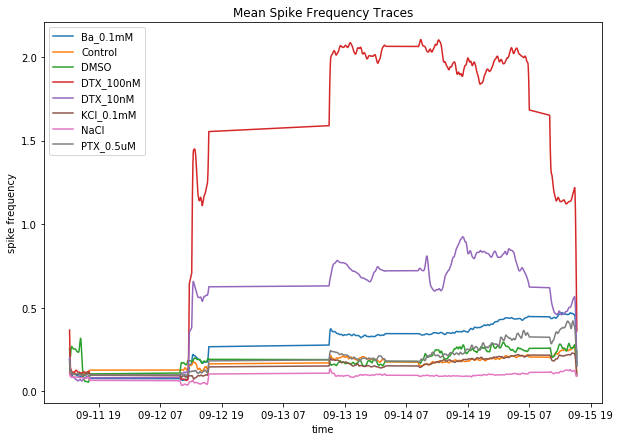

In [60]:
plt.figure(figsize=(10,7))
plotting.plot_mean_frequency_traces(cat_table_inh)

In [27]:
cat_table_lightOFF = baseline2
cat_table_lightON = cat_table_reachr.query('time > "2017-09-11 13:00:00"')
exc_units = []
inh_units = []
for unit in cat_table_reachr['unit_name'].unique():
    unit_OFF = cat_table_lightOFF.query('unit_name == @unit')
    unit_ON = cat_table_lightON.query('unit_name == @unit')
    mean_freq_OFF = np.mean(unit_OFF['spike_freq'])
    mean_freq_ON = np.mean(unit_ON['spike_freq'])
    if mean_freq_ON > mean_freq_OFF:
        exc_units.append(unit)
    else:
        inh_units.append(unit)

In [80]:
len(inh_units)

603

In [28]:
cat_table_reachr_exc = (cat_table_reachr.loc[cat_table_reachr['unit_name'].isin(exc_units)])
cat_table_reachr_inh = (cat_table_reachr.loc[cat_table_reachr['unit_name'].isin(inh_units)])

cat_table_exc = (cat_table.loc[cat_table['unit_name'].isin(exc_units)])
cat_table_inh = (cat_table.loc[cat_table['unit_name'].isin(inh_units)])

baseline_table_exc = (baseline_table.loc[baseline_table['unit_name'].isin(exc_units)])
baseline_table_inh = (baseline_table.loc[baseline_table['unit_name'].isin(inh_units)])

stim_table_exc = (stim_table.loc[stim_table['unit_name'].isin(exc_units)])
stim_table_inh = (stim_table.loc[stim_table['unit_name'].isin(inh_units)])

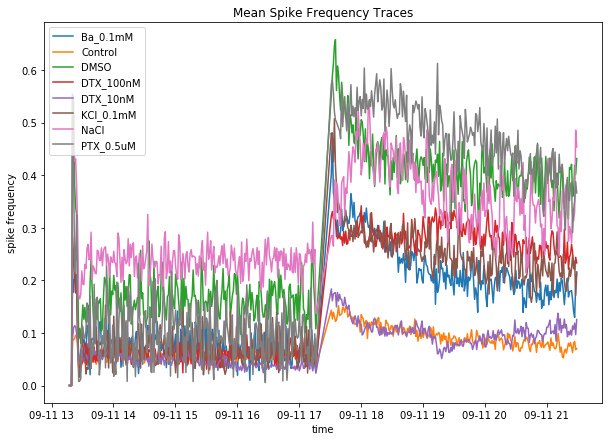

In [61]:
plt.figure(figsize=(10,7))
plotting.plot_mean_frequency_traces(cat_table_reachr_exc)

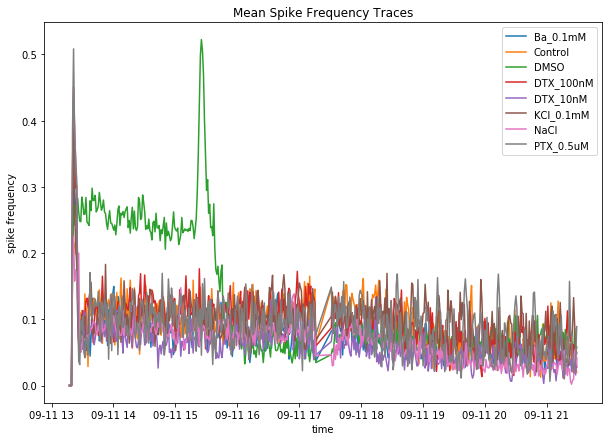

In [62]:
plt.figure(figsize=(10,7))
plotting.plot_mean_frequency_traces(cat_table_reachr_inh)

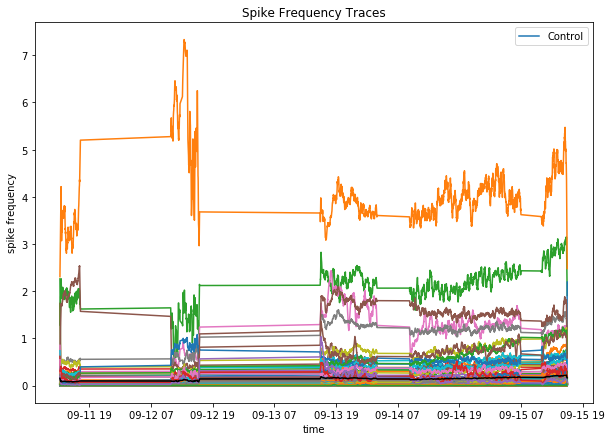

In [18]:
plt.figure(figsize=(10,7))
plotting.plot_unit_traces_plus_means(cat_table.query('condition == "Control"'))# and unit_name > "E"'))
#plt.yscale('log')

pymea/plotting.py:443: RuntimeWarning: invalid value encountered in double_scalars
  continue


24
160


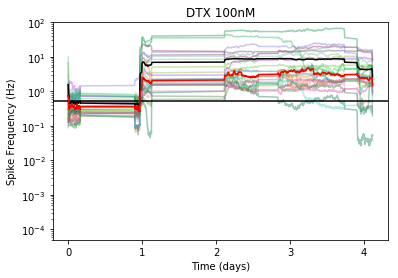

In [55]:
plotting.foldInductionPlusMean(cat_table, baseline_table, stim_table, "DTX_100nM", 'DTX 100nM', var = 10, minHz = 0.2, maxHz = 10, ymax = 100, plotFolds=False)

13
63


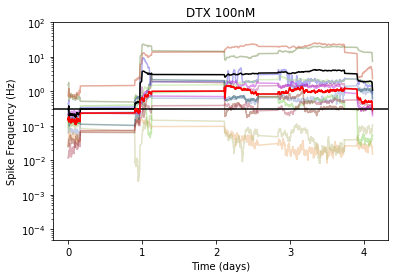

In [56]:
plotting.foldInductionPlusMean(cat_table_exc, baseline_table_exc, stim_table_exc, "DTX_100nM", 'DTX 100nM', var=100, minHz = 0.05, ymax=100, plotFolds=False)

27
97


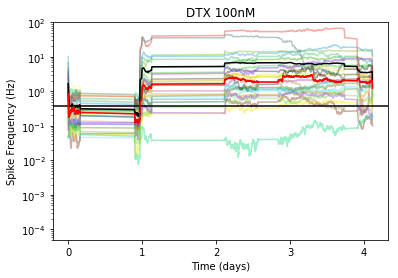

In [57]:
plotting.foldInductionPlusMean(cat_table_inh, baseline_table_inh, stim_table_inh, "DTX_100nM", 'DTX 100nM', var = 100, minHz = 0.05, ymax = 100, plotFolds=False)

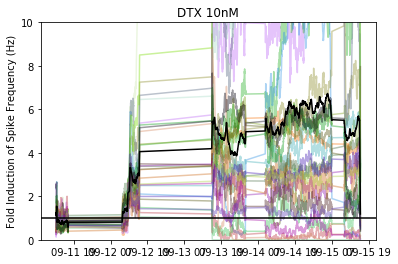

In [24]:
plotting.foldInductionPlusMean(cat_table, baseline_table, stim_table, "DTX_10nM", 'DTX 10nM', minHz = 0.01)

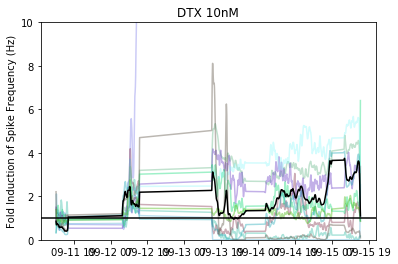

In [65]:
plotting.foldInductionPlusMean(cat_table_exc, baseline_table_exc, stim_table_exc, "DTX_10nM", 'DTX 10nM', minHz = 0.01)

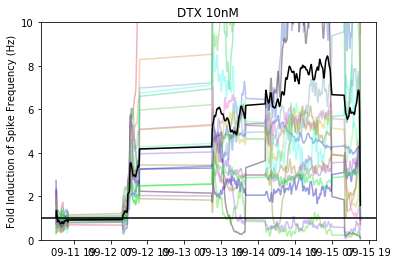

In [66]:
plotting.foldInductionPlusMean(cat_table_inh, baseline_table_inh, stim_table_inh, "DTX_10nM", 'DTX 10nM', minHz = 0.01)

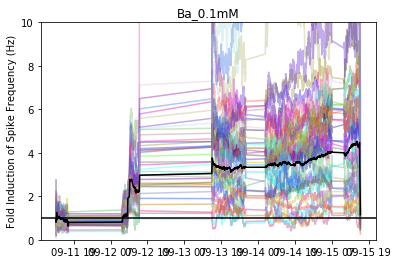

In [25]:
plotting.foldInductionPlusMean(cat_table, baseline_table, stim_table, "Ba_0.1mM", 'Ba_0.1mM', var=2.5, minHz = 0.01) 

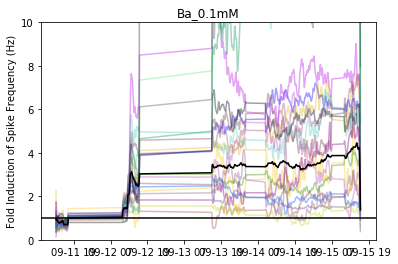

In [67]:
plotting.foldInductionPlusMean(cat_table_exc, baseline_table_exc, stim_table_exc, "Ba_0.1mM", 'Ba_0.1mM', var=2.5, minHz = 0.01) 

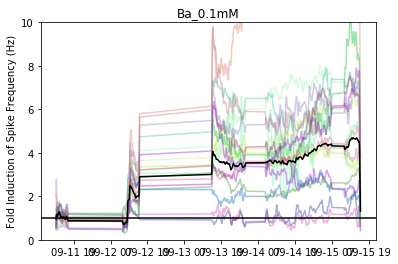

In [68]:
plotting.foldInductionPlusMean(cat_table_inh, baseline_table_inh, stim_table_inh, "Ba_0.1mM", 'Ba_0.1mM', var=2.5, minHz = 0.01) 

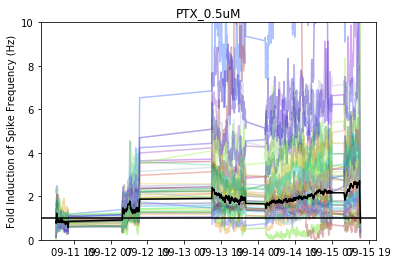

In [26]:
plotting.foldInductionPlusMean(cat_table, baseline_table, stim_table, "PTX_0.5uM", 'PTX_0.5uM', var=2.5, minHz = 0.01)


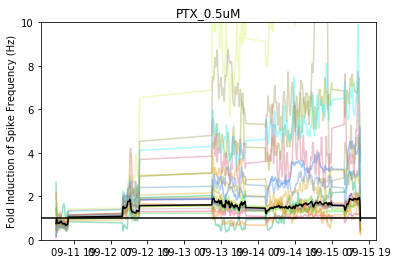

In [69]:
plotting.foldInductionPlusMean(cat_table_exc, baseline_table_exc, stim_table_exc, "PTX_0.5uM", 'PTX_0.5uM', var=2.5, minHz = 0.01)


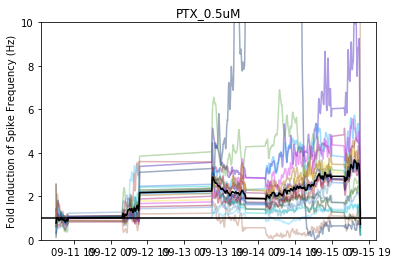

In [70]:
plotting.foldInductionPlusMean(cat_table_inh, baseline_table_inh, stim_table_inh, "PTX_0.5uM", 'PTX_0.5uM', var=2.5, minHz = 0.01)


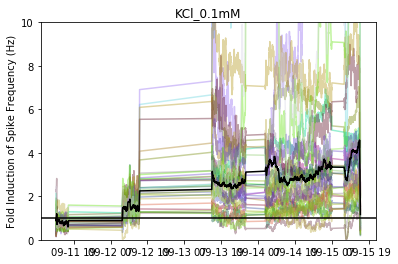

In [27]:
plotting.foldInductionPlusMean(cat_table, baseline_table, stim_table, "KCl_0.1mM", 'KCl_0.1mM', minHz = 0.01)

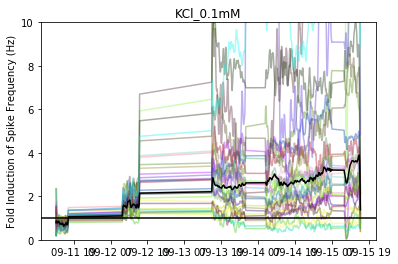

In [71]:
plotting.foldInductionPlusMean(cat_table_exc, baseline_table_exc, stim_table_exc, "KCl_0.1mM", 'KCl_0.1mM', minHz = 0.01)

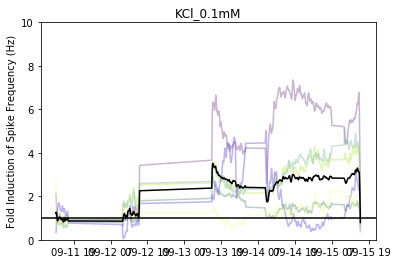

In [72]:
plotting.foldInductionPlusMean(cat_table_inh, baseline_table_inh, stim_table_inh, "KCl_0.1mM", 'KCl_0.1mM', minHz = 0.01)

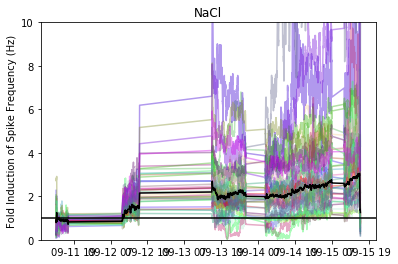

In [28]:
plotting.foldInductionPlusMean(cat_table, baseline_table, stim_table, "NaCl", 'NaCl', minHz = 0.01)

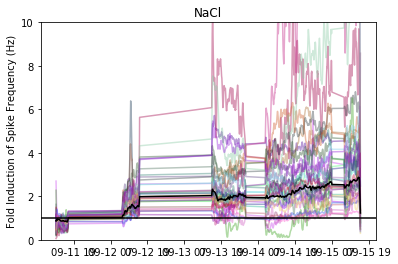

In [73]:
plotting.foldInductionPlusMean(cat_table_exc, baseline_table_exc, stim_table_exc, "NaCl", 'NaCl', minHz = 0.01)

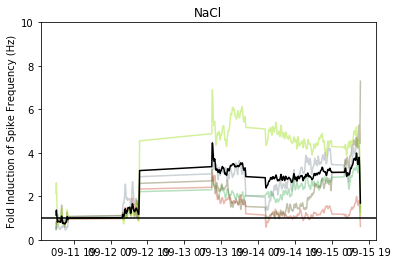

In [74]:
plotting.foldInductionPlusMean(cat_table_inh, baseline_table_inh, stim_table_inh, "NaCl", 'NaCl', minHz = 0.01)

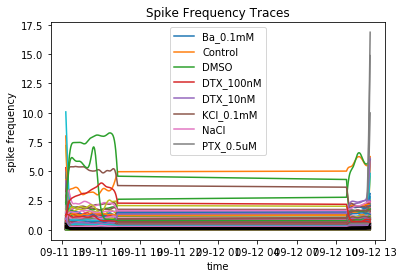

In [12]:
plotting.plot_unit_traces_plus_means(baseline_table)

pymea/plotting.py:508: RuntimeWarning: invalid value encountered in double_scalars
  


28
145


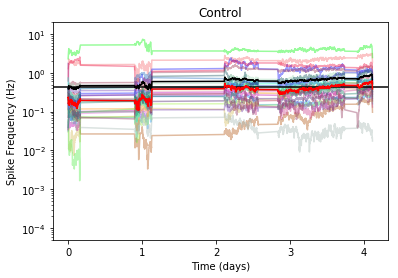

In [54]:
plotting.foldInductionPlusMean(cat_table, baseline_table, stim_table, "Control", 'Control', ind_filter = False, var = 100, minHz = 0.05, maxHz = 100, ymax = 20, plotFolds=False)

11
57


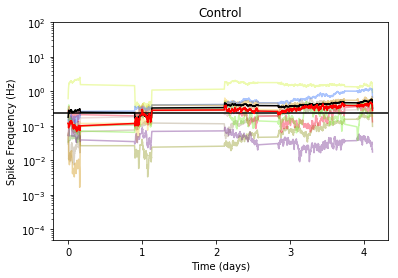

In [58]:
plotting.foldInductionPlusMean(cat_table_exc, baseline_table_exc, stim_table_exc, "Control", 'Control', ind_filter = False, var = 100, minHz = 0.05, maxHz = 100, ymax = 100, plotFolds=False)

17
88


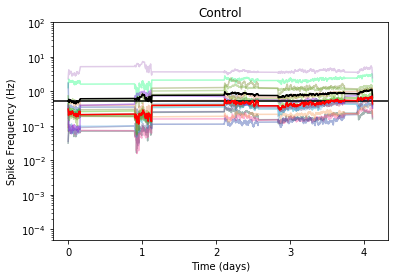

In [60]:
plotting.foldInductionPlusMean(cat_table_inh, baseline_table_inh, stim_table_inh, "Control", 'Control', ind_filter = False, var = 100, minHz = 0.05, maxHz = 100, ymax = 100, plotFolds=False)

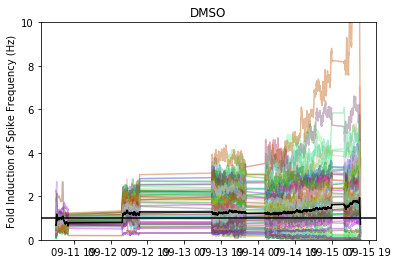

In [30]:
plotting.foldInductionPlusMean(cat_table, baseline_table, stim_table, "DMSO", 'DMSO', ind_filter = False, minHz = 0.01)

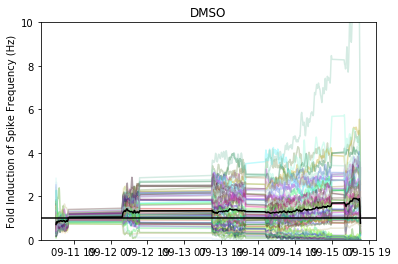

In [77]:
plotting.foldInductionPlusMean(cat_table_exc, baseline_table_exc, stim_table_exc, "DMSO", 'DMSO', ind_filter = False, minHz = 0.01)

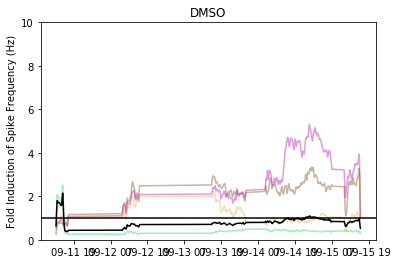

In [78]:
plotting.foldInductionPlusMean(cat_table_inh, baseline_table_inh, stim_table_inh, "DMSO", 'DMSO', ind_filter = False, minHz = 0.01)